# Emotion Classification with Keras Embedding & LSTM

Collection of documents and its emotions, It helps greatly in NLP Classification tasks

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


## Imports

In [3]:
import zipfile
import os
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.decomposition import PCA

## Data Understanding

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emotion_dataset/train.txt', sep=';', header=None, names=['text', 'label'])
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emotion_dataset/val.txt', sep=';', header=None, names=['text', 'label'])
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/emotion_dataset/test.txt', sep=';', header=None, names=['text', 'label'])

In [5]:
train_df.shape, val_df.shape, test_df.shape

((16000, 2), (2000, 2), (2000, 2))

In [6]:
print(train_df.head())
print(val_df.head())
print(test_df.head())

                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
                                                text    label
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3                  i am just feeling cranky and blue    anger
4  i can have for a treat or if i am feeling festive      joy
                                                text    label
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i lef

In [ ]:
print(train_df["label"].value_counts()/len(train_df)*100)
print(val_df["label"].value_counts()/len(val_df)*100)
print(test_df["label"].value_counts()/len(test_df)*100)

## Text Preprocessing

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # punctuations
    text = text.lower()  # lower case
    text = re.sub(r'\d+', '', text)  # numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Stopwords
    text = re.sub(r'\s+', ' ', text).strip()  # space
    return text


train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
label_to_int = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}

train_df['label'] = train_df['label'].map(label_to_int)
val_df['label'] = val_df['label'].map(label_to_int)
test_df['label'] = test_df['label'].map(label_to_int)

In [10]:
train_df.head()

,text,label
0,didnt feel humiliated,1
1,go feeling hopeless damned hopeful around some...,1
2,im grabbing minute post feel greedy wrong,2
3,ever feeling nostalgic fireplace know still pr...,4
4,feeling grouchy,2


## Tokenizer and Text Sequence

text = "Bu bir örnek cümledir."

tokens = ["Bu", "bir", "örnek", "cümledir"]

"Bu" -> 1

"bir" -> 2

"örnek" -> 3

"cümledir" -> 4

sequence = [1, 2, 3, 4]




In [11]:
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])

X_val = tokenizer.texts_to_sequences(val_df['text'])

X_test = tokenizer.texts_to_sequences(test_df['text'])

## Pad Sequences

X_train = [[1, 2, 3], [4, 5, 6, 7, 8], [9]]

max_len = 5


X_train = pad_sequences(X_train, maxlen=max_len)

X_train = [
    [0, 0, 1, 2, 3],       
    [4, 5, 6, 7, 8],       
    [0, 0, 0, 0, 9]       
]




In [12]:
max_len = 100

X_train = pad_sequences(X_train, maxlen=max_len)

X_val = pad_sequences(X_val, maxlen=max_len)

X_test = pad_sequences(X_test, maxlen=max_len)


In [13]:
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

## Modeling with Keras Word Embedding

In [14]:
model = Sequential([
        Embedding(input_dim=max_words,
                  input_length=max_len,
                  output_dim=128,
                  name='embedding_layer'),

        LSTM(128),
        BatchNormalization(),
        Dropout(0.2),
        Dense(6, activation='softmax')

    ])


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 100, 128)          1280000   
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 1412870 (5.39 MB)
Trainable params: 141261

In [15]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    verbose=1,
                    callbacks=early_stopping
                    )

Epoch 1/100
500/500 [==============================] - 19s 28ms/step - loss: 0.7512 - accuracy: 0.7452 - val_loss: 0.7559 - val_accuracy: 0.8130
Epoch 2/100
500/500 [==============================] - 5s 9ms/step - loss: 0.2052 - accuracy: 0.9337 - val_loss: 0.8831 - val_accuracy: 0.7535
Epoch 3/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1306 - accuracy: 0.9567 - val_loss: 0.7443 - val_accuracy: 0.8045
Epoch 4/100
500/500 [==============================] - 4s 8ms/step - loss: 0.0861 - accuracy: 0.9730 - val_loss: 0.4353 - val_accuracy: 0.8840
Epoch 5/100
500/500 [==============================] - 4s 8ms/step - loss: 0.0659 - accuracy: 0.9792 - val_loss: 0.5503 - val_accuracy: 0.8820
Epoch 6/100
500/500 [==============================] - 4s 7ms/step - loss: 0.0602 - accuracy: 0.9798 - val_loss: 0.3958 - val_accuracy: 0.8995
Epoch 7/100
500/500 [==============================] - 4s 8ms/step - loss: 0.0589 - accuracy: 0.9804 - val_loss: 0.3817 - val_accuracy: 0.90

In [16]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Val Loss: {val_loss}", f"Val Accuracy: {val_accuracy}")
print(f"Test Loss: {test_loss}", f"Test Accuracy: {test_accuracy}")

Val Loss: 0.3783871531486511 Val Accuracy: 0.9079999923706055
Test Loss: 0.36910533905029297 Test Accuracy: 0.9020000100135803


In [17]:
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=-1)

classification_rep = classification_report(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)

print(accuracy)
print(classification_rep)

0.902
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       695
           1       0.95      0.95      0.95       581
           2       0.90      0.87      0.88       275
           3       0.84      0.89      0.87       224
           4       0.83      0.75      0.79       159
           5       0.72      0.82      0.77        66

    accuracy                           0.90      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.90      0.90      0.90      2000



# Lets Play with Embeddings

## Embedding Layer

In [18]:
embedding_layer = model.get_layer(name='embedding_layer')

embedding_weights = embedding_layer.get_weights()[0]

In [19]:
embedding_weights

array([[ 1.7637104e-02,  4.0419716e-02, -4.5286018e-02, ...,
        -1.1795142e-03, -9.1894818e-03, -1.5900467e-02],
       [-1.8907206e-02,  5.2170516e-03,  1.3523671e-02, ...,
         1.4110389e-01,  4.2833854e-05, -1.7353935e-02],
       [-4.3444447e-02,  3.1715613e-02,  4.3503739e-02, ...,
         1.2936176e-01, -2.8315928e-02,  2.1038538e-02],
       ...,
       [ 2.4267979e-02, -1.1224052e-02, -4.7242682e-02, ...,
        -1.7378250e-02,  2.6386853e-02, -4.0573608e-02],
       [ 4.8065852e-02, -8.9065798e-02, -4.2285461e-02, ...,
         8.5959516e-02,  1.7514111e-02, -2.3795387e-02],
       [ 7.3594376e-02, -4.3057662e-02, -3.0016225e-02, ...,
         3.0150250e-02,  4.0065283e-03,  4.5629833e-02]], dtype=float32)

## Words Indexes

In [20]:
word_index = tokenizer.word_index

index_word = {v: k for k, v in word_index.items()}

In [21]:
list(index_word.items())[:10]

[(1, 'feel'),
 (2, 'feeling'),
 (3, 'like'),
 (4, 'im'),
 (5, 'really'),
 (6, 'know'),
 (7, 'time'),
 (8, 'get'),
 (9, 'little'),
 (10, 'people')]

## Using Embedding Vectors

In [22]:
happy_index = word_index.get('happy')

sad_index = word_index.get('sad')

In [23]:
happy_vector = embedding_weights[happy_index]

sad_vector = embedding_weights[sad_index]

In [24]:
print("Happy Vector:", happy_vector)
print("Sad Vector:", sad_vector)

Happy Vector: [-0.03633222  0.00871675 -0.01295438 -0.04200436 -0.07961887 -0.03343319
 -0.01759871 -0.05879183 -0.01819821  0.05391103  0.01790288 -0.03127093
 -0.08485623  0.05052254 -0.03955629 -0.08630449 -0.06459962 -0.06971727
  0.06285781 -0.05110549 -0.05275036  0.04818203 -0.0272438  -0.05471143
  0.01248588 -0.04917718 -0.00581401  0.03562924  0.06580183  0.01467859
 -0.05117306  0.01509483 -0.04723376 -0.0373495  -0.02372659 -0.08853536
  0.0118376  -0.01037447 -0.13294703 -0.03433609 -0.04260997 -0.10416016
 -0.03417441 -0.0091548   0.06627085 -0.06596235 -0.06578115 -0.08521262
  0.00912885 -0.00130848 -0.02107397 -0.06501784  0.01110967  0.09776477
  0.11924095 -0.04343928  0.02435283  0.07498957  0.08254627 -0.00614936
  0.11214601 -0.05665026 -0.02137698 -0.12118611 -0.05116544 -0.0996724
 -0.02381937 -0.05487235  0.01165257 -0.01200515 -0.0264256   0.08541805
  0.09976939 -0.01270995 -0.07599436 -0.02163797  0.0129424  -0.1369173
  0.03641098 -0.00815462 -0.02494269 -0

In [25]:
len(happy_vector)

128

## Find Closest Embeddings

In [26]:
def find_closest_embeddings(embedding, word_embedding):
    cosine_similarities = cosine_similarity(embedding, word_embedding.reshape(1, -1))
    return np.argsort(cosine_similarities.flatten())[::-1]

In [27]:
closest_to_happy = find_closest_embeddings(embedding_weights, happy_vector)

In [28]:
for idx in closest_to_happy[:5]:
    print(index_word[idx])

happy
jolly
comfortable
flawless
delicious


In [29]:
closest_to_sad = find_closest_embeddings(embedding_weights, sad_vector)

In [30]:
for idx in closest_to_sad[:5]:
    print(index_word[idx])

sad
embarrassed
hopeless
remorseful
awkward


## Arithmetic Operations with Vectors

In [31]:
result_vector = happy_vector - sad_vector

In [32]:
closest_to_result = find_closest_embeddings(embedding_weights, result_vector)

In [33]:
for idx in closest_to_result[:5]:
    print(index_word[idx])


happy
studied
intelligent
entertained
jolly


In [34]:
angry_index = word_index.get('angry')
angry_vector = embedding_weights[angry_index]

result_vector = happy_vector - sad_vector + angry_vector

In [35]:
closest_to_result = find_closest_embeddings(embedding_weights, result_vector)


for idx in closest_to_result[:5]:
    print(index_word[idx])


acceptance
angry
smoothie
signs
forefront


## 2D Visualization of Emotion Vectors

In [36]:
emotions = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise', 'happy', 'sad', 'angry', 'fear', 'disgust']

emotion_vectors = {emotion: embedding_weights[word_index[emotion]] for emotion in emotions}

In [37]:
def plot_emotions(emotion_vectors):
    vectors = list(emotion_vectors.values())
    labels = list(emotion_vectors.keys())

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(vectors)

    plt.figure(figsize=(10, 10))
    for i, label in enumerate(labels):
        plt.scatter(pca_result[i, 0], pca_result[i, 1])
        plt.annotate(label, (pca_result[i, 0], pca_result[i, 1]))
    plt.title('Emotion Embeddings PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

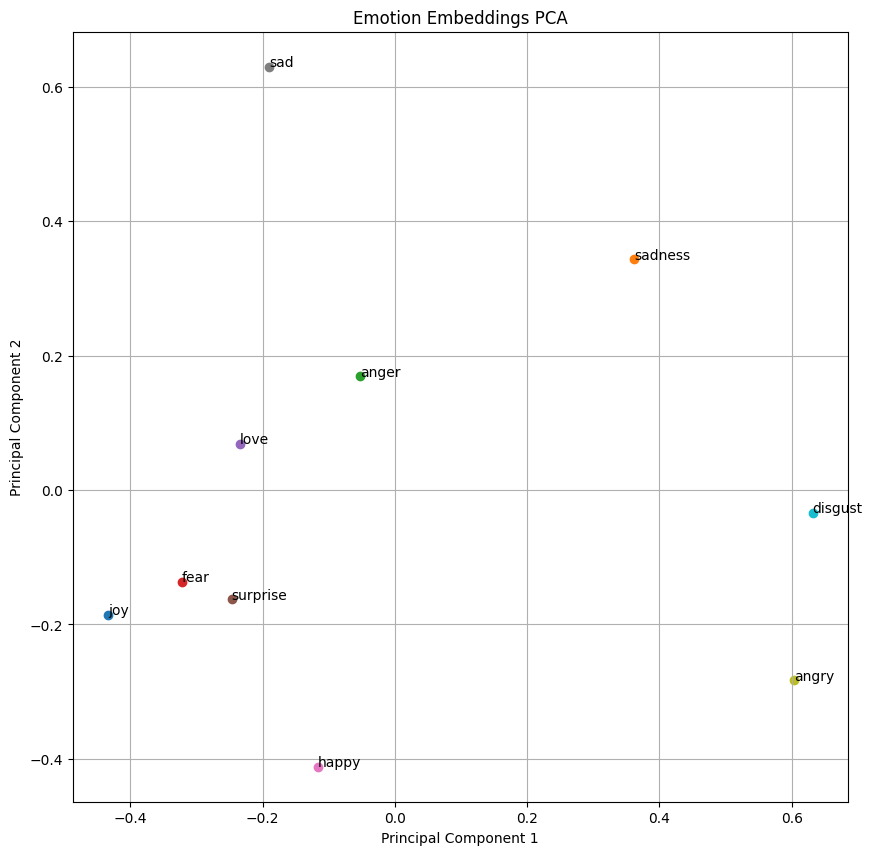

In [38]:
plot_emotions(emotion_vectors)